# Model calibrations using ML

## Structure

- given files containing smiles and parameters, extract data
- train network map f: parameters -> smile
- pick smile, train network g: theta_0 -> theta_guess (theta being parameters)


Author: Joerg Kienitz (finciraptor.de, https://github.com/Lapsilago) for the workshop Machine Learning for Option Pricing, Calibration and Hedging Workshop with Nikolai Nowaczyk ( https://github.com/niknow; https://github.com/niknow/machine-learning-examples )

based on the corresponding github files by Dr. Blanka Horvath, Aitor Muguruza Gonzalez, Mehdi Tomas

## For good results the number of training data, epochs, number of layers need to be adjusted. This is for illustrating the method and reduce the runtime on your computer!

## Extract data

In [2]:
# importing packages and loading training/test data
import os
from io import StringIO
import numpy as np
import numpy.matlib as npm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

dat = np.loadtxt('HestonTrainSet_price.txt')     # train on implied volatilities
#dat = np.loadtxt('surfacesFromNNHeston_ivol.txt')     # train on implied volatilities

In [3]:
# Setting up basic structures

NModelPar = 5                                    # number of model parameters 5 for Heston  
paramdata=dat[:,:NModelPar]                             # model parameters for training data
optdata=dat[:,NModelPar:]                             # output data (prices/implied volatilities)
print(optdata.shape)
print(paramdata.shape)

strikes=np.array([0.75, 0.8, 0.85, 0.9, .95, 1, 1.05, 1.1, 1.15, 1.2, 1.25])    # moneyness
maturities=np.array([0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.5])        # maturities
weights = np.array([1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])
cw = np.ndarray.flatten(npm.repmat(weights,8,1))

(10000, 88)
(10000, 5)


In [4]:
#split the data
from sklearn.model_selection import train_test_split
y_train, y_test, x_train, x_test = train_test_split(
    optdata, paramdata, test_size=0.05, random_state=42)

print(np.shape(x_train))

(9500, 5)


In [5]:
np.shape(y_train)

(9500, 88)

In [6]:
#lower and upper bounds for the parameters; Heston: vInst, vLong, kappa, nu, rho
# we might wish to choose sets with dependent parameters, e.g. vInst and vLong are related
#       kappa and nu scale the variance of the stochastic variance by nu^2/kappa, etc.
# we might wish to restrict kappa since "kappa kills the skew"

# The description is found in Heston_Data.txt
ub=[0.1,0.1,0.25,0.25,-0.5]
lb=[0.0025,0.0025,0.01,0.01,-0.9]

In [7]:
# scaling functions
def myscale(x):
    res=np.zeros(NModelPar)
    for i in range(NModelPar):
        res[i]=(x[i] - (ub[i] + lb[i])*0.5) * 2 / (ub[i] - lb[i])
        
    return res
def myinverse(x):
    res=np.zeros(NModelPar)
    for i in range(NModelPar):
        res[i]=x[i]*(ub[i] - lb[i]) *0.5 + (ub[i] + lb[i])*0.5
        
    return res

In [8]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

scale.fit_transform(y_train)
scale.transform(y_test)

# define suitable scalings for using with the nets
def ytransform(x_train,x_test):
    return [scale.transform(x_train),scale.transform(x_test)]

    
[y_train_transform,y_test_transform]=ytransform(y_train,y_test)

def yinversetransform(x):
    return scale.inverse_transform(x)

In [9]:
x_train_transform = np.array([myscale(y) for y in x_train])
x_test_transform = np.array([myscale(y) for y in x_test])

# Create the Neural Network

In [10]:
# define the neural network in Keras
import keras
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

# initialize to corresponding data type
keras.backend.set_floatx('float64')

# network
input1 = keras.layers.Input(shape=(NModelPar,))             # input layer

x1 = keras.layers.Dense(15,activation = 'elu')(input1)      # hidden layer 1
x2 = keras.layers.Dense(15,activation = 'elu')(x1)          # hidden layer 2   
x3 = keras.layers.Dense(15,activation = 'elu')(x2)          # hidden layer 3 

x4=keras.layers.Dense(88,activation = 'linear')(x3)         # needs to be adjusted wrt output size

# set up the model
NNHeston = keras.models.Model(inputs=input1, outputs=x4)
NNHeston.summary()

# weight that is multiplied to the values at the corresponding strikes
w = K.constant(cw) 


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                90        
_________________________________________________________________
dense_2 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_3 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_4 (Dense)              (None, 88)                1408      
Total params: 1,978
Trainable params: 1,978
Non-trainable params: 0
_________________________________________________________________


# Fit the Neural Network (use .h5 file if previously trained!)

In [11]:
# define the objective function and do the compilation and fitting
# Heston: least squares with weights w
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(w*K.square(y_pred - y_true)))

# compile the model for training using the objective function just defined
NNHeston.compile(loss = root_mean_squared_error, optimizer = "adam")        # weighted rmse, optimizer adam

Nepochs = 10
Nbatches = 32

# the model takes y_train_transform as input (the model smile)
# and it learns the model parameters, the output or predictions
history = NNHeston.fit(x_train_transform, y_train_transform, batch_size=Nbatches,validation_data = (x_test_transform,y_test_transform),epochs = Nepochs, verbose = True,shuffle=1)#,callbacks=[earlystop])

Train on 9500 samples, validate on 500 samples
Epoch 1/10
9500/9500 [==============================] - 4s 393us/step - loss: 0.3551 - val_loss: 0.1346
Epoch 2/10
9500/9500 [==============================] - 1s 121us/step - loss: 0.1063 - val_loss: 0.0897
Epoch 3/10
9500/9500 [==============================] - 1s 116us/step - loss: 0.0799 - val_loss: 0.0683
Epoch 4/10
9500/9500 [==============================] - 1s 118us/step - loss: 0.0615 - val_loss: 0.0515
Epoch 5/10
9500/9500 [==============================] - 1s 117us/step - loss: 0.0497 - val_loss: 0.0437
Epoch 6/10
9500/9500 [==============================] - 1s 116us/step - loss: 0.0431 - val_loss: 0.0407
Epoch 7/10
9500/9500 [==============================] - 1s 118us/step - loss: 0.0387 - val_loss: 0.0358
Epoch 8/10
9500/9500 [==============================] - 1s 113us/step - loss: 0.0356 - val_loss: 0.0327
Epoch 9/10
9500/9500 [==============================] - 1s 114us/step - loss: 0.0334 - val_loss: 0.0324
Epoch 10/10
9500/

dict_keys(['val_loss', 'loss'])


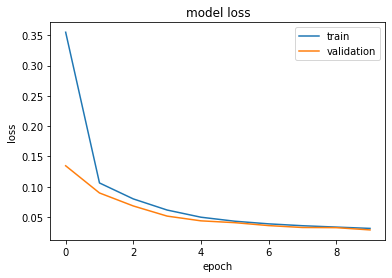

In [12]:
# list all data in history
print(history.history.keys())

# summarize history for loss and plot on training and validation set
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Store/Load optimal NN parameteres

In [13]:
# save the model weights for later use without needing to train
NNHeston.save_weights('HestonNNWeights_price.h5')   # for the price
#NNHeston.save_weights('HestonNNWeights_ivol.h5')   # for the vol

In [14]:
# load the model weights to be used onwards 
NNHeston.load_weights('HestonNNWeights_price.h5')    # for the price
#NNHeston.load_weights('HestonNNWeights_ivol.h5')    # for the vol

In [15]:
NNParameters=[]
for i in range(1,len(NNHeston.layers)):
    NNParameters.append(NNHeston.layers[i].get_weights())

# Compute Prices / Implied vol relative errors on Test set

In [16]:
import numpy as np
#import csv

S0=1.0
strikes_dim=len(strikes)
maturities_dim=len(maturities)
strikeslabel=np.round(np.linspace(strikes[0],strikes[-1],8),1)
maturitieslabel=np.array([0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.5])     # needs to be adjusted if other maturities are used

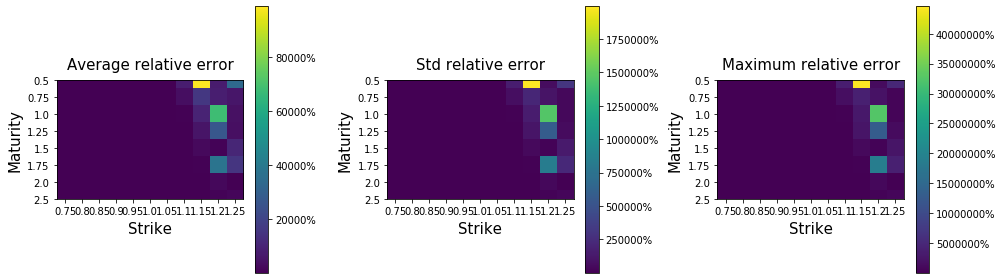

In [17]:

##### AVERAGE VALUES #######
Y_sample = yinversetransform(y_test_transform) # the realizations
X_sample = x_test_transform                    # the parameters

Scaling_0 = 100.0

prediction = [yinversetransform(NNHeston.predict(X_sample[i].reshape(1,NModelPar))[0]) for i in range(len(X_sample))]
plt.figure(1,figsize=(14,4))
ax=plt.subplot(1,3,1)
err = np.mean(Scaling_0*np.abs((Y_sample-prediction)/Y_sample),axis = 0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,2)
err = Scaling_0*np.std(np.abs((Y_sample-prediction)/Y_sample),axis = 0)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,3)
err = Scaling_0*np.max(np.abs((Y_sample-prediction)/Y_sample),axis = 0)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
plt.tight_layout()
#plt.savefig('HestonNNErrors.png', dpi=300)
plt.show()

# Plot sample Prices/Smiles

C:\Users\Kienitz_All\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


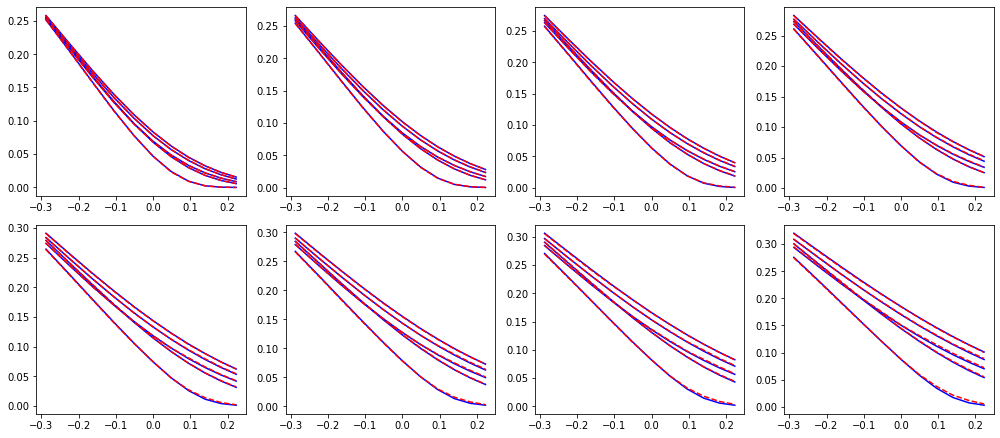

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import scipy

S0=1.0
NStart = 0
for jj in range(5):
    Y_sample = y_test[NStart+jj]
    X_sample = x_test_transform[NStart+jj]

    prediction=yinversetransform(NNHeston.predict(X_sample.reshape(1,NModelPar))[0])
    plt.figure(1,figsize=(14,12))
    for i in range(maturities_dim):
        plt.subplot(4,4,i+1)
    
        plt.plot(np.log(strikes/S0),Y_sample[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
        plt.plot(np.log(strikes/S0),prediction[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")
    plt.tight_layout()
    
    

plt.show()

23606.567514655075 0.00708591270482254 33 10 25 86
abs 0.004046483028933852 a diff 0.011132395733756392 0.00708591270482254 r diff 0.6365128292498768
rel 2.8546568932271744e-08 -0.0006738579602424957 a diff 0.000673886506811428 r diff 23606.567514655075
0.00708591270482254 23606.567514655075
index 33 10


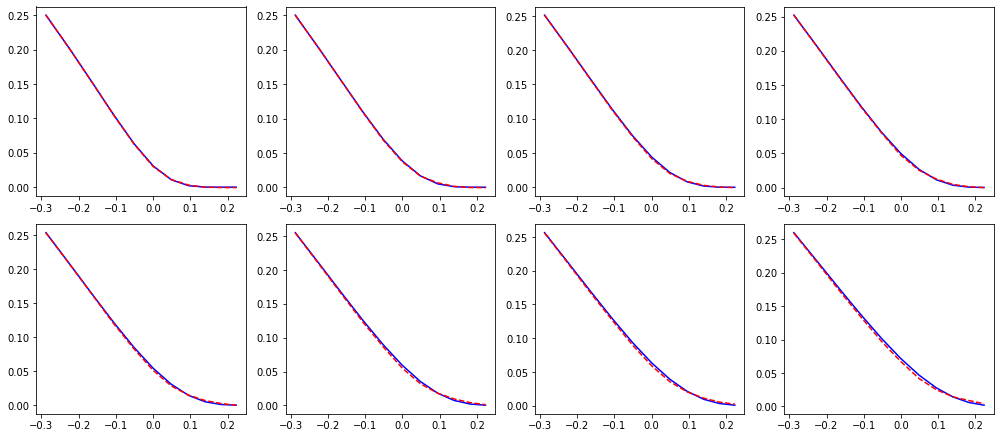

In [19]:
# find the worst cases for absolute and relative differences; calculate and plot
S0=1.
NStart = 0
mx = 0.0
rval = 0.0
aval = 0.0

absdiffval = 0.0
reldiffval =  0.0

for jj in range(50):
    Y_sample = y_test[NStart+jj]
    X_sample = x_test_transform[NStart+jj]
    predictiony=yinversetransform(NNHeston.predict(X_sample.reshape(1,NModelPar))[0])
    absdiffvall = absdiffval
    reldiffvall = reldiffval
    
    absdiff = np.absolute(Y_sample - predictiony)
    reldiff = np.divide(absdiff,Y_sample)
    
    absdiffval = max(np.amax(absdiff),absdiffval)
    reldiffval = max(np.amax(reldiff),reldiffval)
    if absdiffval > absdiffvall:
        ind = np.unravel_index(np.argmax(absdiff, axis=None), absdiff.shape)
    if reldiffval > reldiffvall:
        ind = np.unravel_index(np.argmax(reldiff, axis=None), reldiff.shape)
 
    for kk in range(0,87):
        rvall = rval
        avall = aval
        val = abs(Y_sample[kk]-predictiony[kk])
        rval = max(abs(Y_sample[kk]-predictiony[kk])/Y_sample[kk], rval)
        aval = max(abs(Y_sample[kk] - predictiony[kk]),aval)
        if rval > rvall:
            indexj = jj
            indexk = kk
        if aval > avall:
            indexjj = jj
            indexkk = kk
    
print(rval, aval, indexj, indexk, indexjj, indexkk)

yy_sample_test = y_test[indexj]
xxx = np.array([myscale(x) for x in x_test])
xx_sample_test = xxx[indexj]

# predict the values on the test data
prediction_test = yinversetransform(NNHeston.predict(xx_sample_test.reshape(1,NModelPar))[0])
# now we plot the outcome for prediction using yy_sample_test against true values xx_sample_test
plt.figure(1,figsize=(14,12))
for i in range(maturities_dim):
    plt.subplot(4,4,i+1)
    
    plt.plot(np.log(strikes/S0),yy_sample_test[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
    plt.plot(np.log(strikes/S0),prediction_test[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")
plt.tight_layout()

predictiony=yinversetransform(NNHeston.predict(x_test_transform[indexjj].reshape(1,NModelPar))[0])
xvaly = y_test[indexjj,indexkk]
xvalx = predictiony[indexkk]
print('abs',xvaly, 'a diff', xvalx, xvalx-xvaly, 'r diff', (xvalx-xvaly)/xvalx)
predictiony=yinversetransform(NNHeston.predict(x_test_transform[indexj].reshape(1,NModelPar))[0])
xvalx = y_test[indexj,indexk]
xvaly = predictiony[indexk]
print('rel',xvalx, xvaly, 'a diff', xvalx-xvaly, 'r diff', (xvalx-xvaly)/xvalx)
print(absdiffval, reldiffval)
print('index',indexj,indexk)

In [20]:
# now we use the Net directly on some new generated test data
# the data has the same structure as the data for training
TestData=np.loadtxt("surfacesFromNNHeston_price.txt")
#TestData=np.loadtxt("surfacesFromNNHeston_ivol.txt")
xx_sample = TestData[:,:NModelPar]                       # the model parameters
yy_sample = TestData[:,NModelPar:]                       # the prices/ivols corresponding to the parameters


[ 0.0651116   0.06284858  0.1522356   0.02623259 -0.61062279]


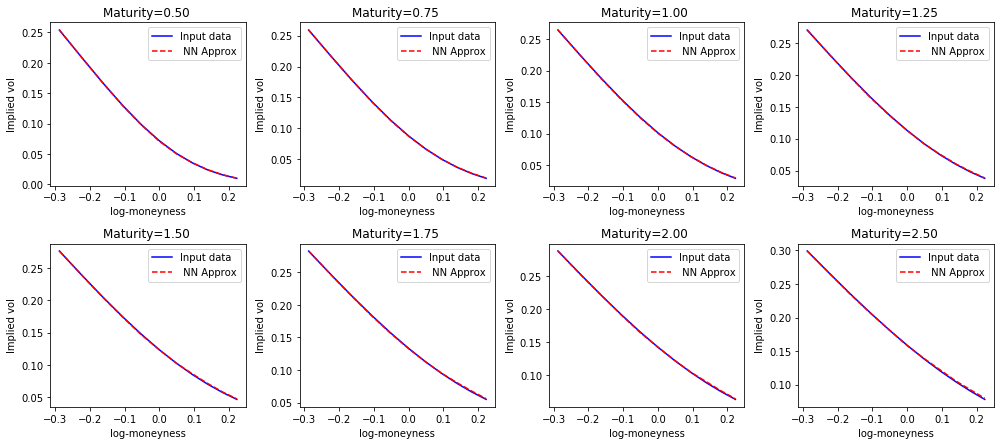

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import scipy
S0=1.

sample_ind = 23
Y_sample = y_test[sample_ind]
X_sample = x_test_transform[sample_ind]
#print(scale.inverse_transform(y_sample))
print(myinverse(X_sample))

prediction=yinversetransform(NNHeston.predict(X_sample.reshape(1,NModelPar))[0])
plt.figure(1,figsize=(14,12))
for i in range(maturities_dim):
    plt.subplot(4,4,i+1)
    
    plt.plot(np.log(strikes/S0),Y_sample[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
    plt.plot(np.log(strikes/S0),prediction[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")

    
    plt.title("Maturity=%1.2f "%maturities[i])
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied vol")
    
    plt.legend()
plt.tight_layout()
plt.show()


# Use gradient methods for optimization

In [22]:
# load test data
SurfacesCalib=np.loadtxt("surfacesFromNNHeston_price.txt")
#SurfacesCalib=np.loadtxt("surfacesFromNNHeston_ivol.txt")

SurfacesCalib.shape

(500, 93)

In [23]:
SurfacesCalibTarget = SurfacesCalib[:,:NModelPar]  # SurfacesCalib[:,:NModelPar] - the target parameters from the data set
SurfacesCalibVal=SurfacesCalib[:,NModelPar:]       # the results (prices/vol) are stored in this variable

SurfacesCalibVal_transform = SurfacesCalibVal #scale2.transform(SurfacesCalibVal)
SurfacesCalibParams = SurfacesCalib[:,:NModelPar]                 # ???

xx_test = SurfacesCalib #SurfacesCalib[:,:NModelPar]
xx_test_transform = np.array([myscale(x) for x in xx_test])


In [24]:
np.shape(SurfacesCalibTarget)

(500, 5)

For calibration we might wish to use a faster method
This uses the same idea given in the notebooks from Horvath, Muguruza Gonzalez, Tomas

In [25]:
NumLayers=3
def elu(x):
    #Careful function ovewrites x
    ind=(x<0)
    x[ind]=np.exp(x[ind])-1
    return x
def eluPrime(y):
    # we make a deep copy of input x
    x=np.copy(y)
    ind=(x<0)
    x[ind]=np.exp(x[ind])
    x[~ind]=1
    return x
def NeuralNetwork(x):
    input1=x
    for i in range(NumLayers):
        input1=np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
        #Elu activation
        input1=elu(input1)
    #The output layer is linnear
    i+=1
    return np.dot(input1,NNParameters[i][0])+NNParameters[i][1]

def NeuralNetworkGradient(x):
    input1=x
    #Identity Matrix represents Jacobian with respect to initial parameters
    grad=np.eye(NModelPar)
    #Propagate the gradient via chain rule
    for i in range(NumLayers):
        input1=(np.dot(input1,NNParameters[i][0])+NNParameters[i][1])
        grad=(np.einsum('ij,jk->ik', grad, NNParameters[i][0]))
        #Elu activation
        grad*=eluPrime(input1)
        input1=elu(input1)
    #input1.append(np.dot(input1[i],NNParameters[i+1][0])+NNParameters[i+1][1])
    grad=np.einsum('ij,jk->ik',grad,NNParameters[i+1][0])
    #grad stores all intermediate Jacobians, however only the last one is used here as output
    return grad
        

In [26]:
# may we introduce weights for the corresponding points!?
def CostFunc(x,indexs):
    return np.sum(cw*np.power((NeuralNetwork(x)-SurfacesCalibVal_transform[indexs]),2))
def Jacobian(x,indexs):
    return 2*np.sum(cw*(NeuralNetwork(x)-SurfacesCalibVal_transform[indexs])*NeuralNetworkGradient(x),axis=1)
#Cost Function for Levenberg Marquardt
def CostFuncLS(x,indexs):
    return cw*(NeuralNetwork(x)-SurfacesCalibVal_transform[indexs])
def JacobianLS(x,indexs):
    return NeuralNetworkGradient(x).T

In [27]:
import time
import scipy
NOpt = 4;     # number of Optimizers
NRuns = 50;   # Number of runs
Approx=[]
Timing=[]
#sample_ind = 500
#X_sample = X_test[sample_ind]
#y_sample = y_test_transform[sample_ind]
solutions=np.zeros([NOpt,NModelPar])          # stores the solutions from optimization   
times=np.zeros(NOpt)                          # just stores the times 
init=np.zeros(NModelPar)                      # initialize @ zero but could be other starting values, e.g. smart parameters
for i in range(NRuns):
    disp=str(i+1)+"/"+str(NRuns)
    print (disp,end="\r")
    #L-BFGS-B
    start= time.clock()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='L-BFGS-B',jac=Jacobian,tol=1E-10,options={"maxiter":5000})
    end= time.clock()
    solutions[0,:]=myinverse(I.x)
    times[0]=end-start
    #SLSQP
    start= time.clock()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='SLSQP',jac=Jacobian,tol=1E-10,options={"maxiter":5000})
    end= time.clock()
    solutions[1,:]=myinverse(I.x)
    times[1]=end-start
    #BFGS
    start= time.clock()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='BFGS',jac=Jacobian,tol=1E-10,options={"maxiter":5000})
    end= time.clock()
    solutions[2,:]=myinverse(I.x)
    times[2]=end-start
    #Levenberg-Marquardt
    start= time.clock()
    I=scipy.optimize.least_squares(CostFuncLS,init, JacobianLS,args=(i,),gtol=1E-10)
    end= time.clock()
    solutions[3,:]=myinverse(I.x)
    times[3]=end-start
    #I=scipy.optimize.minimize(costfunc,x0=init,method='COBYLA',options={"maxiter":2000})
    #print(I)
    Approx.append(np.copy(solutions))
    Timing.append(np.copy(times))


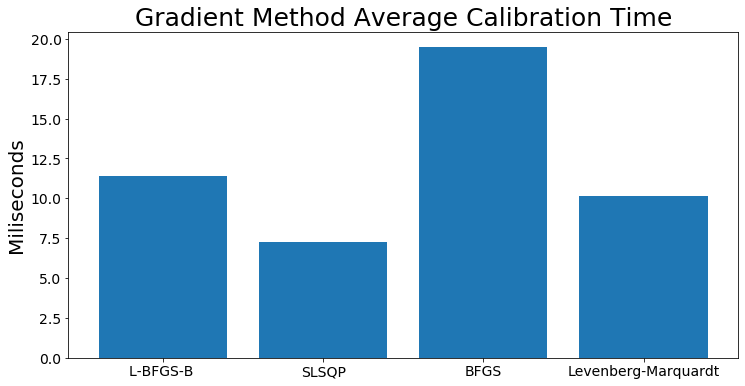

In [28]:
methods=["L-BFGS-B ","SLSQP","BFGS","Levenberg-Marquardt"]
plt.figure(1,figsize=(12,6))
plt.bar(methods,np.mean(Timing,axis=0)*1000)
plt.title("Gradient Method Average Calibration Time",fontsize=25)
plt.ylabel("Miliseconds",fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

# Save the  Optimal parameters

In [29]:
# choose optimizer 0 -> L-BFGS-B, 1 -> SLSQP, 2-> BFGS, 3-> Levenberg 
NOpti = 1
OptParameters=[Approx[i][NOpti] for i in range(len(Approx))]
np.savetxt("OptParamHeston_price.txt",OptParameters)  
#np.savetxt("NNParametersHeston_ivol.txt",OptParameters)  

# Calibration Errors 

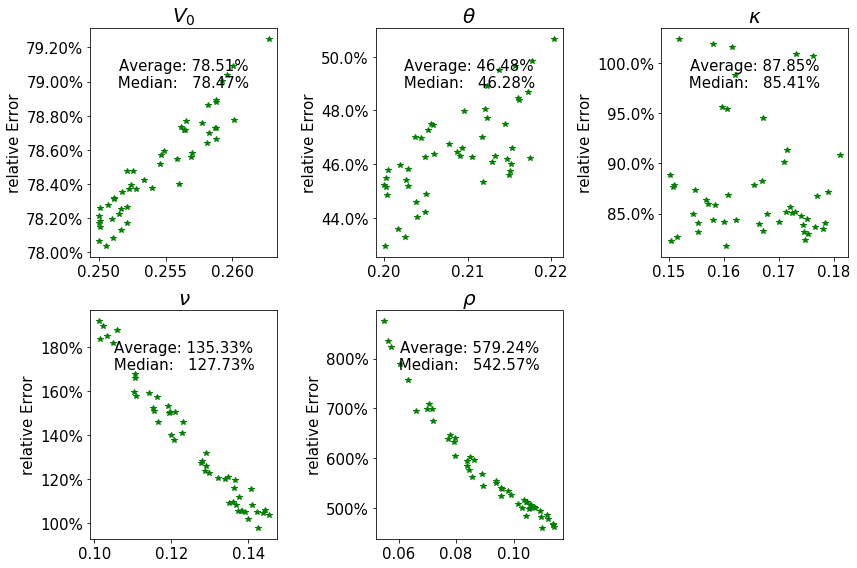

In [30]:
titles=["$V_0$", "$\\theta$", "$\\kappa$","$\\nu$","$\\rho$"]
Scaling = 100.0

average=np.zeros([5,NRuns])
fig=plt.figure(figsize=(12,8))
for u in range(NModelPar):
    ax=plt.subplot(2,3,u+1)
    for i in range(NRuns):        
        y=y_test[i][u]
        plt.plot(y,Scaling*np.abs(OptParameters[i][u]-y)/np.abs(y),'g*')
        average[u,i]=np.abs(OptParameters[i][u]-y)/np.abs(y)
    plt.title(titles[u],fontsize=20)
    plt.ylabel('relative Error',fontsize=15)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.text(0.5, 0.8, 'Average: %1.2f%%\n Median:   %1.2f%% '%(np.mean(Scaling*average[u,:]),np.quantile(Scaling*average[u,:],0.5)), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)

plt.tight_layout()
plt.savefig('HestonParameterRelativeErrors.png', dpi=300)
#plt.savefig('HestonParameterRelativeErrors_ivol.png', dpi=300)
plt.show()

# Load corresponding smile generated by Integration Methods

In [108]:
# split the data into parameters and corresponding targets
SurfacesCalibTarget = x_test[:5000] # SurfacesCalib[:,:NModelPar] # the target parameters from the data set
SurfacesCalibVal=SurfacesCalib[:,NModelPar:]    # the results (prices/vol) are stored in this variable

SurfacesCalibParams = SurfacesCalib[:,:NModelPar]                 # ???



RMSENN=np.sqrt(np.mean(np.power(SurfacesCalibVal-fullprediction,2),axis=1))
ind=~(RMSENN==np.inf)
RMSENN=RMSENN[ind]

In [35]:
fullprediction = yinversetransform(NNHeston.predict(SurfacesCalibTarget))

[ 0.01742416  0.02496153  0.08193439  0.08086342 -0.87058109]


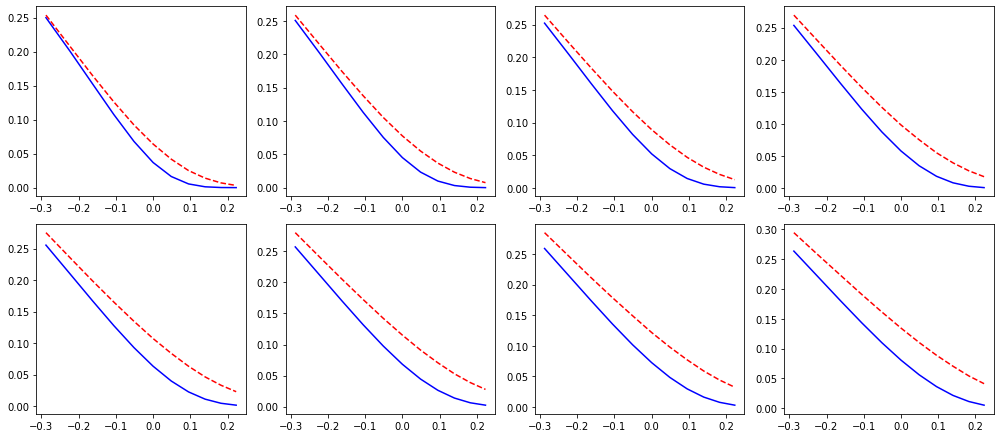

In [49]:
S0=1.
NStart = 50

Y_sample = SurfacesCalibVal[NStart]
X_sample = SurfacesCalibTarget[NStart]

print(X_sample)
    
prediction=yinversetransform(NNHeston.predict(X_sample.reshape(1,NModelPar))[0])
    
plt.figure(1,figsize=(14,12))
for i in range(maturities_dim):
    plt.subplot(4,4,i+1)
    plt.plot(np.log(strikes/S0),Y_sample[i*strikes_dim:(i+1)*strikes_dim],'b',label="True Values")
    plt.plot(np.log(strikes/S0),prediction[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")
    plt.tight_layout()

plt.show()

rms max 0.054332828975010475  at index 7 ; rms min 0.0018185350274734335  at index 23
[-0.00401522 -0.00792182 -0.01453183 -0.02453103 -0.03772385 -0.05195309
 -0.04102425 -0.02422789 -0.01311107 -0.00626521 -0.0026201  -0.00883684
 -0.01478303 -0.02326969 -0.03489981 -0.04890357 -0.06408912 -0.05367288
 -0.03561472 -0.02197092 -0.01257549 -0.0065524  -0.01402692 -0.02127855
 -0.03124626 -0.04366212 -0.05872746 -0.07431773 -0.06411928 -0.04511352
 -0.03001816 -0.0189415  -0.01104786 -0.01887637 -0.02749875 -0.03821856
 -0.05148947 -0.06693502 -0.08291911 -0.07319379 -0.05321022 -0.03735554
 -0.02494873 -0.01595711 -0.02392989 -0.03315619 -0.04461297 -0.05862817
 -0.0745503  -0.09073122 -0.08102742 -0.06086017 -0.04394008 -0.03056105
 -0.02046426 -0.02853883 -0.03853844 -0.05080697 -0.06527614 -0.08145063
 -0.09792898 -0.08791721 -0.06785439 -0.05006337 -0.03581027 -0.02492662
 -0.03293282 -0.04347908 -0.05598868 -0.07094856 -0.08796616 -0.10402941
 -0.09461777 -0.07423616 -0.0559982  -

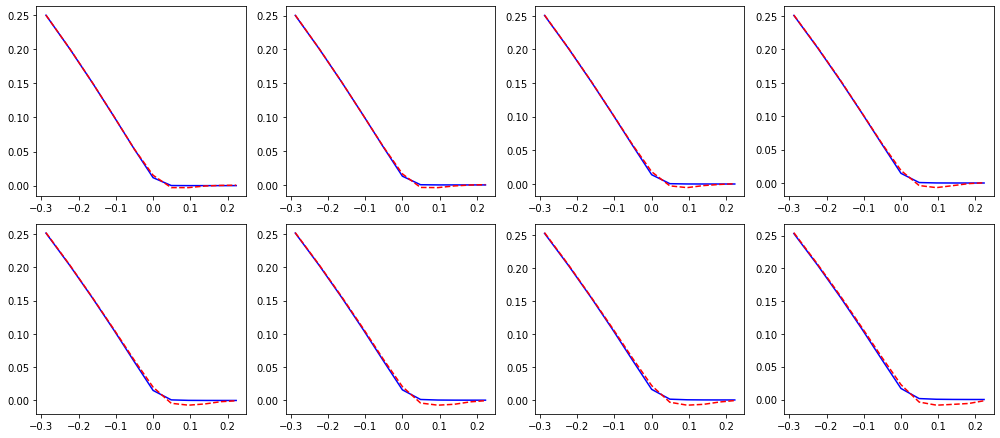

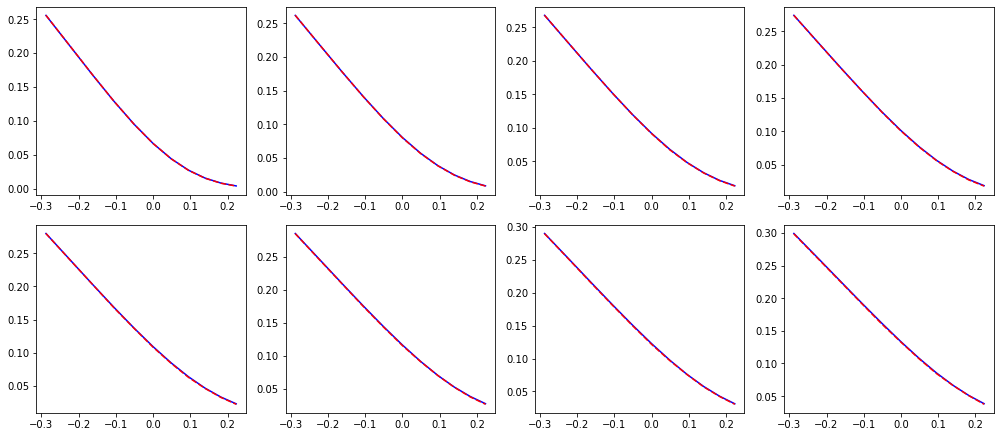

In [36]:
rmserrmax = 0.0
rmserrmin = 1000.0

for jj in range(50):
    rmserrn= np.sqrt(np.mean(np.power(fullprediction[jj,:]-SurfacesCalibVal[jj,:],2)))
    if rmserrn > rmserrmax:
        rmserrmax = rmserrn
        maxindex = jj
    if rmserrn < rmserrmin:
        rmserrmin = rmserrn
        minindex = jj
        

print('rms max', rmserrmax,' at index', maxindex, '; rms min', rmserrmin, ' at index', minindex)

print(SurfacesCalibVal[maxindex]-fullprediction[maxindex])

print(SurfacesCalibVal[minindex]-fullprediction[minindex])

S0=1.
Y_sample = SurfacesCalibVal[maxindex]
#X_sample = SurfacesCalibTarget[minindex]
X_sample = xx_test_transform[maxindex]

prediction=yinversetransform(NNHeston.predict(X_sample.reshape(1,NModelPar))[0])
# prediction
plt.figure(1,figsize=(14,12))
for i in range(8):
    plt.subplot(4,4,i+1)
    plt.plot(np.log(strikes/S0),Y_sample[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
    plt.plot(np.log(strikes/S0),prediction[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")
    #plt.plot(np.log(strikes/S0),X_sample[i*strikes_dim:(i+1)*strikes_dim]-prediction[i*strikes_dim:(i+1)*strikes_dim],'--k',label=" Diff")

plt.tight_layout()  

plt.show()


Y_sample = SurfacesCalibVal[minindex]
#X_sample = SurfacesCalibTarget[minindex]
X_sample = xx_test_transform[minindex]

prediction=yinversetransform(NNHeston.predict(X_sample.reshape(1,NModelPar))[0])
# prediction
plt.figure(1,figsize=(14,12))
for i in range(8):
    plt.subplot(4,4,i+1)
    plt.plot(np.log(strikes/S0),Y_sample[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
    plt.plot(np.log(strikes/S0),prediction[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")
    #plt.plot(np.log(strikes/S0),X_sample[i*strikes_dim:(i+1)*strikes_dim]-prediction[i*strikes_dim:(i+1)*strikes_dim],'--k',label=" Diff")
plt.tight_layout()  

plt.show()

0.009010413371744084 32853.88732625706 0.009010413371744084 74 31 7 84
abs x 0.03341323247020052 abs y 0.031538224435113046 abs diff 0.001875008035087472 rel diff 0.05611573309345906
rel 0.010013278418610431 0.010405477723334063 abs diff -0.00039219930472363107 rel diff -0.03916792166636445


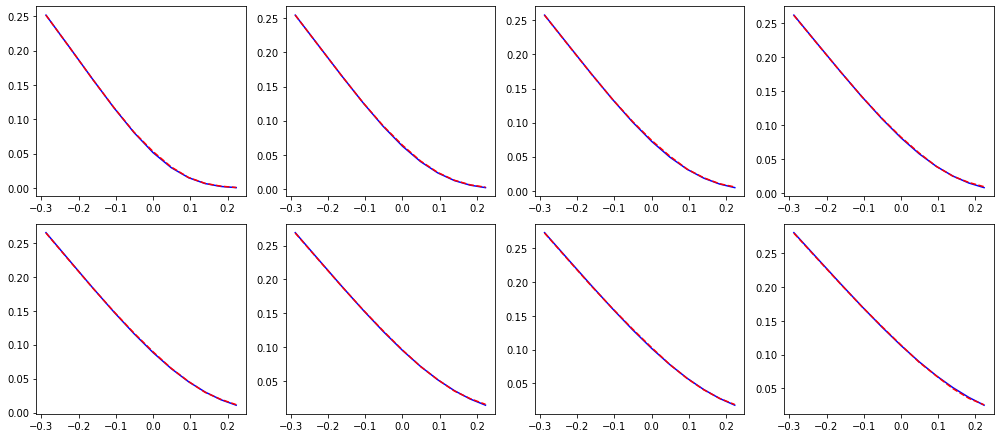

In [37]:
# find the worst cases for absolute and relative differences; calculate and plot
S0=1.
NStart = 0
mval = 0.0
mx = 0.0
rval = 0.0
aval = 0.0

for jj in range(100):
    Y_sample = SurfacesCalibVal[NStart+jj]
    X_sample = xx_test_transform[NStart+jj]
    predictiony=yinversetransform(NNHeston.predict(X_sample.reshape(1,NModelPar))[0])

    for kk in range(0,87):
        rvall = rval
        avall = aval
        val = abs(Y_sample[kk]-predictiony[kk])
        rval = max(abs(Y_sample[kk]-predictiony[kk])/Y_sample[kk], rval)
        aval = max(abs(Y_sample[kk] - predictiony[kk]),aval)
        if rval > rvall:
            indexj = jj
            indexk = kk
        if aval > avall:
            indexjj = jj
            indexkk = kk
        mval = max(val,mval)

print(mval, rval, aval, indexj, indexk, indexjj, indexkk)

yy_sample_test = y_test[indexj]
#XT_sample_test = SurfacesCalibTarget[indexj]
xxx = np.array([myscale(x) for x in x_test])
xx_sample_test = xxx[indexj]

# predict the values on the test data
prediction_test = yinversetransform(NNHeston.predict(xx_sample_test.reshape(1,NModelPar))[0])
# now we plot the outcome for prediction using yy_sample_test against true values xx_sample_test
plt.figure(1,figsize=(14,12))
for i in range(maturities_dim):
    plt.subplot(4,4,i+1)
    
    plt.plot(np.log(strikes/S0),yy_sample_test[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
 #   plt.plot(np.log(strikes/S0),XT_sample_test[i*strikes_dim:(i+1)*strikes_dim],'--k',label="Target data")
    plt.plot(np.log(strikes/S0),prediction_test[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")
plt.tight_layout()

predictiony=yinversetransform(NNHeston.predict(x_test_transform[indexjj].reshape(1,NModelPar))[0])
xvalx = y_test[indexjj,indexkk]
xvaly = predictiony[indexkk]
print('abs x',xvalx, 'abs y', xvaly, 'abs diff', xvalx-xvaly, 'rel diff', (xvalx-xvaly)/xvalx)
predictiony=yinversetransform(NNHeston.predict(x_test_transform[indexj].reshape(1,NModelPar))[0])
xvalx = y_test[indexj,indexk]
xvaly = predictiony[indexk]
print('rel',xvalx, xvaly, 'abs diff', xvalx-xvaly, 'rel diff', (xvalx-xvaly)/xvalx)

In [38]:
# optimize
#NSamples = 20000; 
NSamples = 50;
RMSENN=np.sqrt(np.mean(np.power(SurfacesCalibVal-fullprediction,2),axis=1))
ind=~(RMSENN==np.inf)

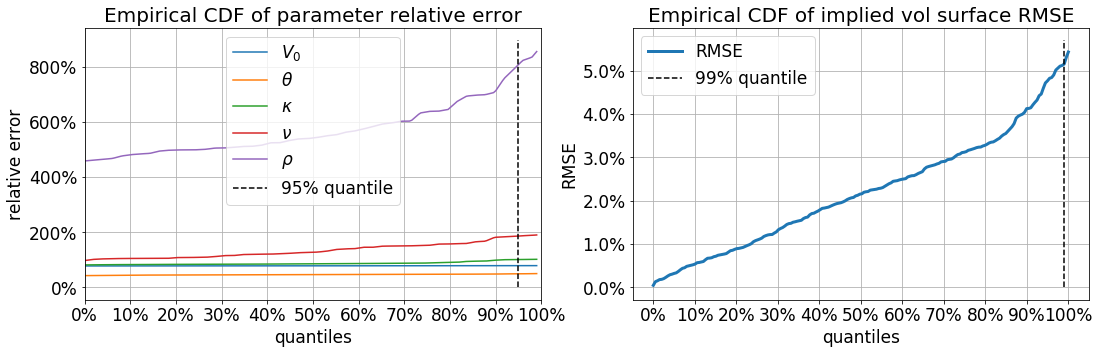

In [40]:
plt.figure(figsize=(18, 5))
plt.clf()
plt.subplot(121)
Scaling = 100.0

ax = plt.gca()
q=np.linspace(0,0.99,200)
for u in range(5):
    p=plt.plot(Scaling*q,np.quantile(Scaling*average[u,:],q),label=titles[u])
    
    c=p[0].get_color()
ymin, ymax = ax.get_ylim()
ax.set_xlim(0,100)
plt.plot(Scaling*np.ones(2)*0.95,np.array([0,ymax]),'--k',label="95% quantile")
plt.title("Empirical CDF of parameter relative error",fontsize=20)
plt.legend(fontsize=17)
plt.xlabel("quantiles",fontsize=17)
plt.ylabel("relative error",fontsize=17)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter() )
plt.tick_params(axis='both', which='major', labelsize=17)
plt.tick_params(axis='both', which='minor', labelsize=17)
plt.xticks(np.arange(0, 101, step=10))

plt.grid()
plt.subplot(122)


ax = plt.gca()
q=np.linspace(0,1,200)
p=plt.plot(Scaling*q,np.quantile(Scaling*RMSENN,q),linewidth=3,label="RMSE")
ymin, ymax = ax.get_ylim()
plt.plot(Scaling*np.ones(2)*0.99,np.array([0,ymax]),'--k',label="99% quantile")
plt.title("Empirical CDF of implied vol surface RMSE",fontsize=20)
plt.legend(fontsize=17)
plt.xlabel("quantiles",fontsize=17)
plt.ylabel("RMSE",fontsize=17)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter() )
plt.tick_params(axis='both', which='major', labelsize=17)
plt.tick_params(axis='both', which='minor', labelsize=17)
plt.xticks(np.arange(0, 101, step=10))
plt.grid()
plt.savefig('HestonErrorCDF.png', dpi=300)
plt.show()
